In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


In [2]:
train = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv')

## EDA

We basically have 4 dimensions under which we need to explore the data:
* time
* country
* store
* product

Given the categorical nature of the data, the most obvious would be to have a time series plot of each product's sales for each location (country + store) so 12 plots in total with 4 lines on each.

In [3]:
train

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...,...
70123,70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158
70126,70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135


In [4]:
train.describe()

,row_id,num_sold
count,70128.000000,70128.000000
mean,35063.500000,194.296986
std,20244.354176,126.893874
min,0.000000,19.000000
25%,17531.750000,95.000000
50%,35063.500000,148.000000
75%,52595.250000,283.000000
max,70127.000000,986.000000


In [5]:
test.describe()

,row_id
count,17520.000000
mean,78887.500000
std,5057.732694
min,70128.000000
25%,74507.750000
50%,78887.500000
75%,83267.250000
max,87647.000000


In [6]:
test.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


#### Checking if any NA

In [7]:
train.isna().sum()

row_id      0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [8]:
test.isna().sum()

row_id     0
date       0
country    0
store      0
product    0
dtype: int64

#### Checking categorical unique values

In [9]:
print(train['product'].unique())

['Kaggle Advanced Techniques' 'Kaggle Getting Started'
 'Kaggle Recipe Book' 'Kaggle for Kids: One Smart Goose']


In [10]:
print(test['product'].unique())

['Kaggle Advanced Techniques' 'Kaggle Getting Started'
 'Kaggle Recipe Book' 'Kaggle for Kids: One Smart Goose']


In [11]:
print(train['country'].unique())

['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain']


In [12]:
print(test['country'].unique())

['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain']


In [13]:
print(train['store'].unique())

['KaggleMart' 'KaggleRama']


In [14]:
print(test['store'].unique())

['KaggleMart' 'KaggleRama']


In [15]:
from itertools import product

In [16]:
for i in product(['x1', 'x2','x3'], ['a,','b']):
    print(i)

('x1', 'a,')
('x1', 'b')
('x2', 'a,')
('x2', 'b')
('x3', 'a,')
('x3', 'b')


In [21]:
train['product'].unique()

array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
      dtype=object)

In [24]:
train.loc[train['product']=='Kaggle Advanced Techniques','product'] = 'A'
train.loc[train['product']=='Kaggle Getting Started','product'] = 'B'
train.loc[train['product']=='Kaggle Recipe Book','product'] = 'C'
train.loc[train['product']=='Kaggle for Kids: One Smart Goose','product'] = 'D'

In [26]:
prods = train['product'].unique()
countries = train['country'].unique()
stores = train['store'].unique()

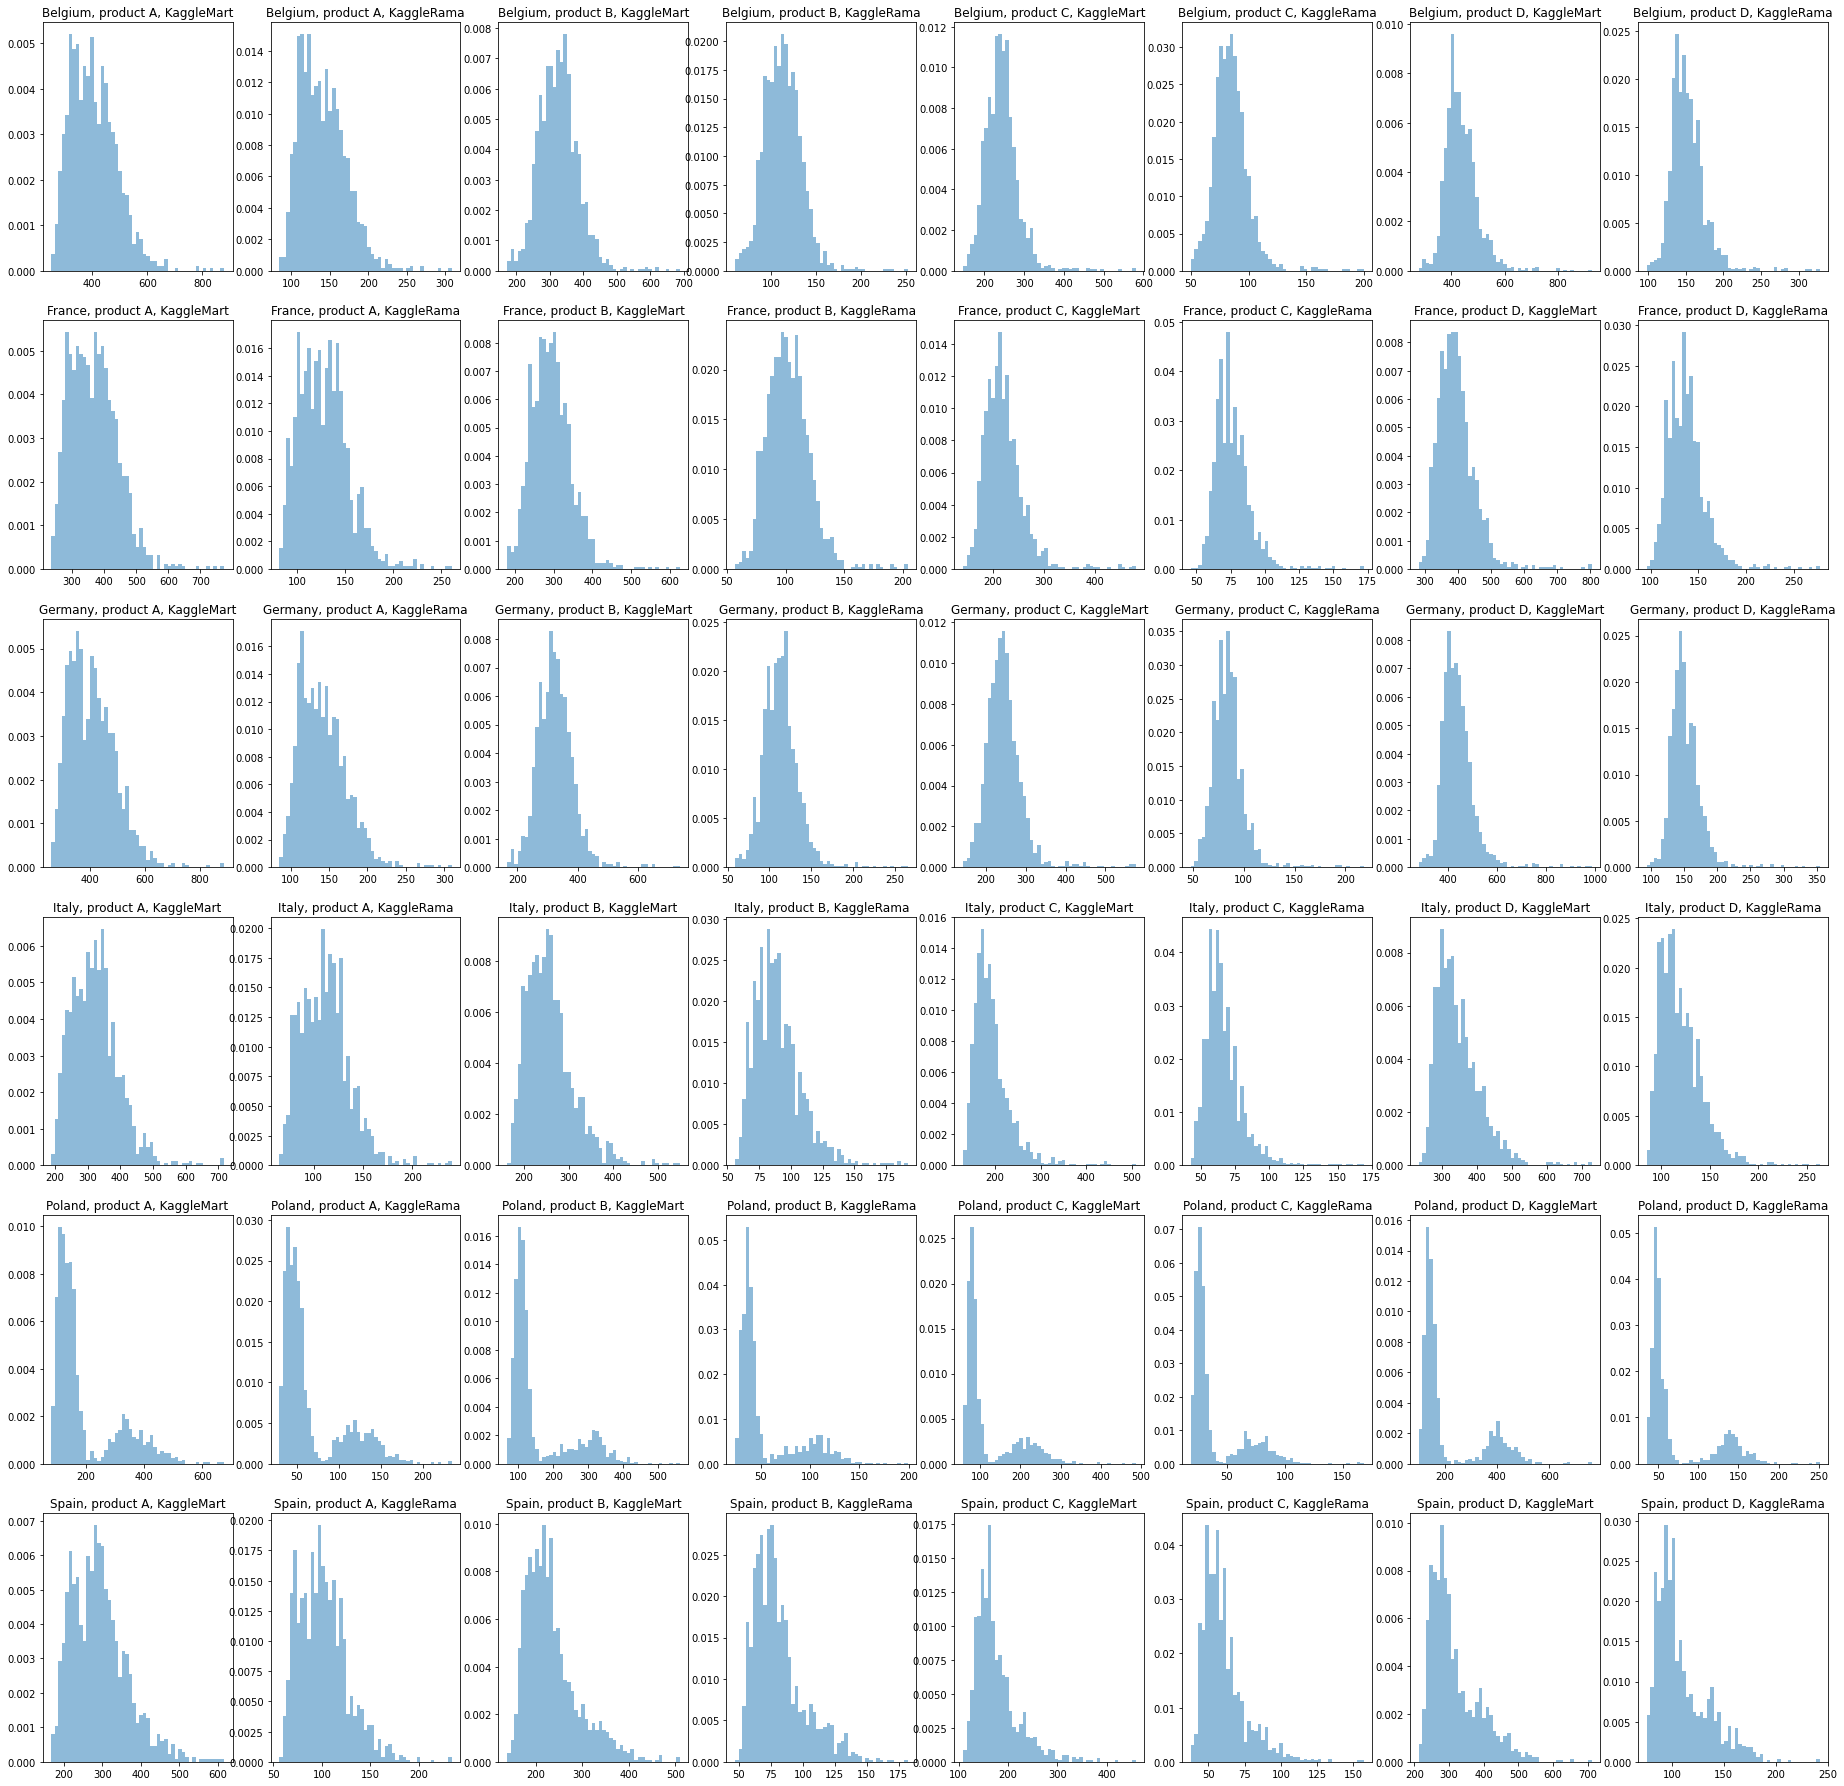

In [35]:
all_combinations = [x for x in product(countries, prods, stores)]

_, axs = plt.subplots(6,8, figsize=(32,32))

for x, ax in zip(all_combinations, axs.ravel()):
    tmp_train = train[(train['country'] == x[0]) & (train['product'] == x[1]) & (train['store'] == x[2])]

    mi = tmp_train['num_sold'].min()
    ma = tmp_train['num_sold'].max()
    bins = np.linspace(mi, ma, 50)
    ax.hist(tmp_train['num_sold'], bins=bins, alpha=0.5, density=True, label='train')
#     ax.set_ylabel(x[0])
    ax.set_title('{c}, product {p}, {s}'.format(c=x[0], p=x[1], s=x[2]))
    
plt.show()

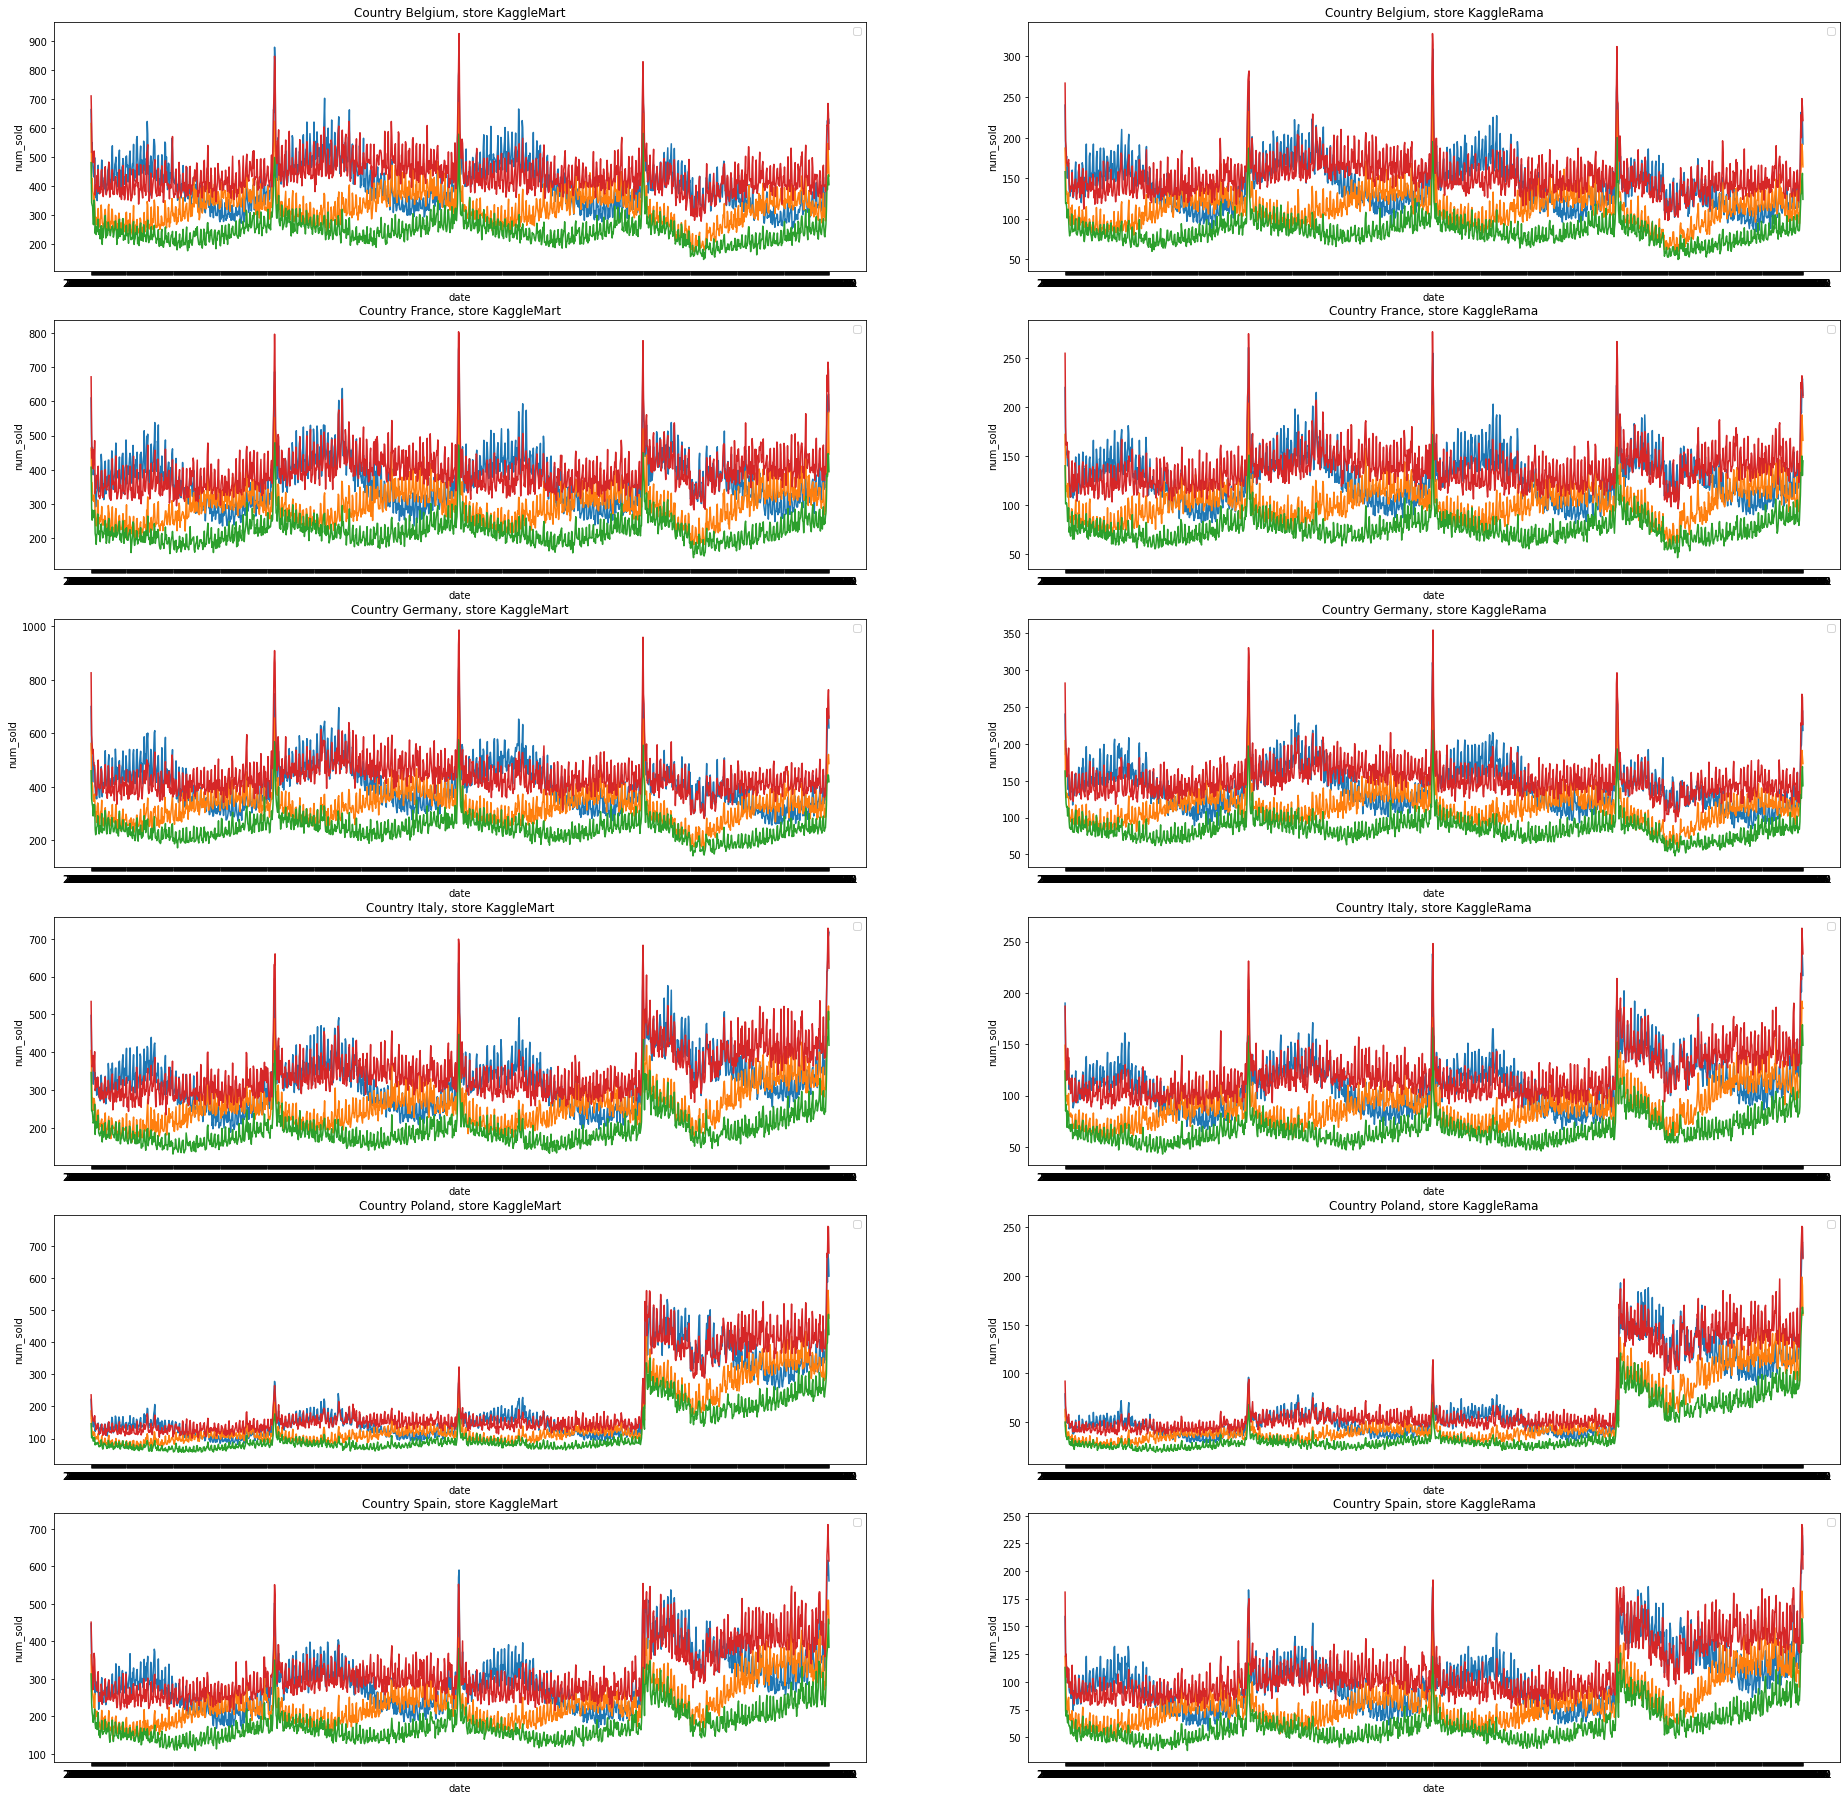

In [56]:
_, axs = plt.subplots(6,2, figsize=(32,32))

for x, ax in zip([x for x in product(countries, stores)], axs.ravel()):

    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'A') & (train['store'] == x[1]) & (train['country'] == x[0])],ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'B') & (train['store'] == x[1]) & (train['country'] == x[0])],ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'C') & (train['store'] == x[1]) & (train['country'] == x[0])],ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'D') & (train['store'] == x[1]) & (train['country'] == x[0])],ax=ax)
    ax.set_title('Country {c}, store {s}'.format(c=x[0], s=x[1]))
    ax.legend()
plt.show()

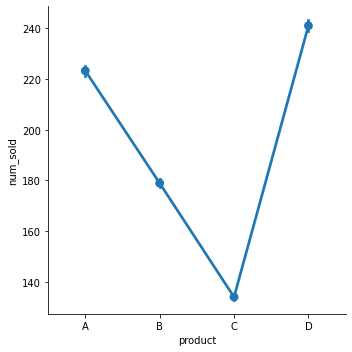

In [53]:
sns.catplot(x="product", y="num_sold", kind="point", data=train)

## Modelling 

* SARIMA
* Create day of the week and months features to capture seasonality 

### Feature engineering

In [57]:
train.date.day

AttributeError: 'Series' object has no attribute 'day'